# A computational introduction to stochastic differential equations.

Lecture 4.

https://github.com/spdes/computational-sde-intro-lecture.

In this notebook we exemplify some methods for estimating the conditional moments of SDE.

Note that this notebook uses package `tme`.

In [1]:
import math
import jax.numpy as jnp
import jax.random
import tme.base_jax as tme
from functools import partial
from jax.config import config
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

Define the SDE coefficients. This is a geometric Brownian motion. We are interested in computing $\mathbb{E}[(X(t))^n \mid X(0) = x_0]$ for some $n$.

In this example, we let $x_0 = 1$ and $t=0.1$.

In [2]:
a, b = -3., 1.


def drift(x):
    return a * x


def dispersion(x):
    return b * x


x0 = 1.
t = 0.1

This SDE is analytically solvable, and its raw moments are also in closed-form, since $X(t)$ is log-Normal distributed for all $t$.

In [3]:
@partial(jax.vmap, in_axes=[0])
def theoretical_raw_moment(n):
    mu = (a - b ** 2 / 2) * t + jnp.log(x0)
    sigma = b * math.sqrt(t)
    return jnp.exp(n * mu + n ** 2 * sigma ** 2 / 2)


def euler_maruyama_analytical_raw_moment(ns):
    mean = x0 + drift(x0) * t
    scale = dispersion(x0) * math.sqrt(t)

    def raw_moment_of_standard_normal(_n):
        if _n % 2 == 0:
            return math.factorial(_n) / (2 ** (_n / 2) * math.factorial(int(_n / 2)))
        else:
            return 0.

    return jnp.asarray([sum([math.comb(n, m) * mean ** m * scale ** (n - m) * raw_moment_of_standard_normal(n - m)
                             for m in range(n + 1)]) for n in ns])


@partial(jax.vmap, in_axes=[None, None, 0])
@partial(jax.vmap, in_axes=[0, None, None])
def euler_maruyama_mc_raw_moment(n, N, key):
    samples = x0 + drift(x0) * t + dispersion(x0) * math.sqrt(t) * jax.random.normal(key, (N,))
    return jnp.mean(samples ** n)


@partial(jax.vmap, in_axes=[0])
def tme_raw_moment(n):
    return tme.expectation(lambda u: u ** n, jnp.array([x0]), t,
                           drift=drift, dispersion=dispersion, order=3)[0]

In [4]:
# Moment orders of interests
moment_orders = jnp.arange(1, 10)

# Compute the theoretical true raw moments
true_rms = theoretical_raw_moment(moment_orders)

# Approximate raw moments from Euler--Maruyama analytically
em_analytical_rms = euler_maruyama_analytical_raw_moment(moment_orders)

# Approximate raw moments from Euler--Maruyama and Monte Carlo
key = jax.random.PRNGKey(666)
npairs = 20
key = jax.random.split(key, npairs)
em_mc_rms = euler_maruyama_mc_raw_moment(moment_orders, 10000, key)

# Approximate raw moment using 3-order TME
tme_rms = tme_raw_moment(moment_orders)

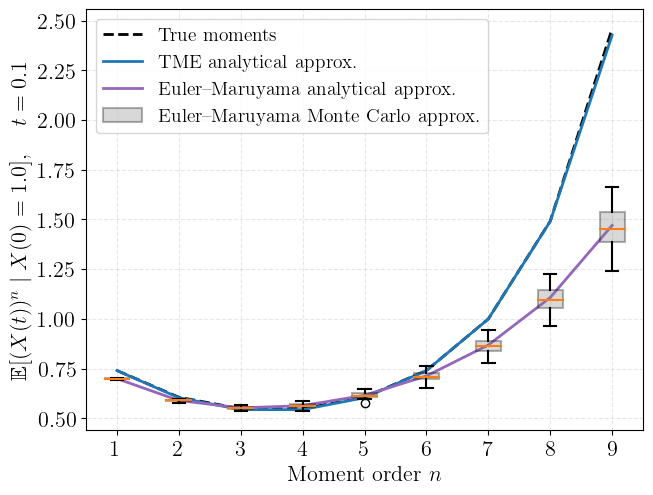

In [8]:
# Plot
plt.rcParams.update({
    'text.usetex': True,
    'font.family': "serif",
    'text.latex.preamble': r'\usepackage{amsmath,amsfonts}',
    'font.serif': ["Computer Modern Roman"],
    'font.size': 16})

p1, = plt.plot(moment_orders, true_rms, linewidth=2, linestyle='--', c='black')
p2, = plt.plot(moment_orders, tme_rms, linewidth=2, c='tab:blue')
p3, = plt.plot(moment_orders, em_analytical_rms, linewidth=2, c='tab:purple')
bp = plt.boxplot(em_mc_rms.T, positions=moment_orders, widths=0.4,
                 patch_artist=True,
                 whiskerprops={'linewidth': 1.5},
                 capprops={'linewidth': 1.5},
                 boxprops={'linewidth': 1.5, 'facecolor': 'tab:gray', 'alpha': 0.3},
                 medianprops={'linewidth': 1.5},
                 meanprops={'linewidth': 1.5, 'linestyle': ':'})

plt.grid(linestyle='--', alpha=0.3, which='both')
plt.xlabel('Moment order $n$')
plt.ylabel(r'$\mathbb{E}[(X(t))^n \mid X(0)=' + f'{x0}]' + ', \quad$' + f' $t={t}$')
plt.legend(handles=[p1, p2, p3, bp['boxes'][0]],
           labels=['True moments',
                   'TME analytical approx.',
                   'Euler--Maruyama analytical approx.',
                   'Euler--Maruyama Monte Carlo approx.'], fontsize=14)

plt.tight_layout(pad=0.1)
plt.subplots_adjust(left=0.126)

Results:

- The TME method for this model can well approximate the moments even for high order moments.
- The Euler--Maruyama seems to fail to give reasonable moment approximation after the moment order > 5.
- Euler--Maruyama + Monte Carlo estimator variance increases significantly as the moment order goes up.